In [1]:
import numpy as np
import pandas as pd
import os
import configparser

In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
project_path = config["PATH"]["PROJECT"]
print(project_path)

/home/severine/MOOCS/UDACITY/BIG_DATA/CAPSTONE_PROJECT


# Parsing functions

## US counties geographic info from Gazeeter

In [4]:
def counties_lat_long_(name):
    with open(name) as f :
        headers = f.readline().split()
        l_headers = len(headers)
        print("len of headers : ", l_headers )
        l_res = []
        for line in f :
            l_str = line.split()
            state = l_str[0]
            fips = l_str[1]
            latitude = l_str[-2]
            longitude = l_str[-1]
            l = len(l_str)
            n_words = l - l_headers + 1
            county = " ".join( l_str[3:3+n_words] )
            #d_res.setdefault(state, []).append( [ state, county, fips, latitude, longitude ])
            l_res.append( [state, county, int(fips), latitude, longitude ])
        return l_res


In [5]:
def counties_lat_long(name):
    l_gazeeter = counties_lat_long_(name)
    df_gazeeter = pd.DataFrame(l_gazeeter, columns = ["state", "county", "fips", "latitude", "longitude"])
    return df_gazeeter

# Read data

In [6]:
data_root = os.path.join(project_path, 'DATA/')

In [7]:
nyt = pd.read_csv( os.path.join(data_root, "us-counties.txt") )
nyt = nyt.astype( {"fips" : 'Int64', "deaths": 'Int64'})
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [8]:
nyt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988671 entries, 0 to 988670
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    988671 non-null  object
 1   county  988671 non-null  object
 2   state   988671 non-null  object
 3   fips    979486 non-null  Int64 
 4   cases   988671 non-null  int64 
 5   deaths  967414 non-null  Int64 
dtypes: Int64(2), int64(1), object(3)
memory usage: 47.1+ MB


In [9]:
gazeeter_counties= counties_lat_long( os.path.join(data_root,"2020_Gaz_counties_national.txt"))
print("number of counties from Gazeeter : ", len(gazeeter_counties))
gazeeter_counties.head()

len of headers :  10
number of counties from Gazeeter :  3221


,state,county,fips,latitude,longitude
0,AL,Autauga County,1001,32.532237,-86.64644
1,AL,Baldwin County,1003,30.659218,-87.746067
2,AL,Barbour County,1005,31.870253,-85.405104
3,AL,Bibb County,1007,33.015893,-87.127148
4,AL,Blount County,1009,33.977358,-86.56644


In [10]:
gazeeter_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3221 entries, 0 to 3220
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   state      3221 non-null   object
 1   county     3221 non-null   object
 2   fips       3221 non-null   int64 
 3   latitude   3221 non-null   object
 4   longitude  3221 non-null   object
dtypes: int64(1), object(4)
memory usage: 125.9+ KB


# Map NY Times location to Gazeeter locations

Check that all fips are unique in Gazeeter

In [11]:
gaz_counts = gazeeter_counties["fips"].value_counts()
len( gaz_counts[gaz_counts>1]) # 0 : all fips are unique !

0

In [12]:
nyt_location = nyt[ ["state", "county", "fips"] ].drop_duplicates()
len(nyt_location)

3274

unique fips in New York Times data

In [13]:
len(nyt_location["fips"].unique())

3219

There are fewer unique fips than total fips => some must be duplicates. 
Check that duplicate fips are missing values

In [14]:
nyt_location.groupby("fips", dropna = False).count().sort_values( ["state", "county"], ascending = False).head()

,state,county
fips,,
NaN,56,56
1001,1,1
1003,1,1
1005,1,1
1007,1,1


Remove empty fips so that we can join with a one-to-one match

In [15]:
nytimes_counties_withfips = nyt_location[ nyt_location["fips"] != '']
nytimes_counties_nofips = nyt_location[nyt_location["fips"].isna() ]
f"NYT : total={len(nyt_location)} with fips= {len(nytimes_counties_withfips)}  no fips = {len(nytimes_counties_nofips)}"

'NYT : total=3274 with fips= 3218  no fips = 56'

In [16]:
nytimes_geo = pd.merge(nytimes_counties_withfips, gazeeter_counties, how = "inner", on = "fips", validate = "one_to_one")
len(nytimes_geo), len(nytimes_counties_withfips)

(3212, 3218)

Fips in NYT that are not found in gazeeter

In [17]:
unknown_fips = set(nytimes_counties_withfips["fips"]) - set(nytimes_geo["fips"])
nytimes_unknown_fips = nytimes_counties_withfips[ nytimes_counties_withfips["fips"].isin(unknown_fips)]
nytimes_unknown_fips

,state,county,fips
37818,Virgin Islands,St. Croix,78010
37819,Virgin Islands,St. John,78020
37820,Virgin Islands,St. Thomas,78030
121367,Alaska,Valdez-Cordova Census Area,2261
333508,Northern Mariana Islands,Saipan,69110
333509,Northern Mariana Islands,Tinian,69120


Locations in NYT that do not have any fips associated with

In [18]:
nytimes_counties_nofips.sort_values("state")

,state,county,fips
26170,Alaska,Unknown,<NA>
9521,Arizona,Unknown,<NA>
5223,Arkansas,Unknown,<NA>
7215,California,Unknown,<NA>
7246,Colorado,Unknown,<NA>
19893,Connecticut,Unknown,<NA>
46082,Delaware,Unknown,<NA>
7304,Florida,Unknown,<NA>
5385,Georgia,Unknown,<NA>
2422,Guam,Unknown,<NA>


New York : New York, Kings, Queens, Bronx and Richmond  :40.712740°N 74.005974°W
Kansas City (Missouri) : Kansas City town, can belong to Cass, Clay, Jackson and Platte county :  39.099724, and the longitude is -94.578331
Joplin (Missouri) : city :37.0842° N, 94.5133° W
Puerto Rico

In [34]:
#nb of cases and death per location
# the data are cumulative, so the max of data for one location is the total number of cases/deaths for this locations
nb_covid_per_location = nyt.groupby(["state", "county", "fips"], dropna=False).max().reset_index()
total_cases = nb_covid_per_location["cases"].sum()
total_deaths = nb_covid_per_location["deaths"].sum()
print(f"total cases : {total_cases}; total deaths : {total_deaths}")
# rank of location for number of deaths
nb_covid_per_location["rank_cases"] = nb_covid_per_location["cases"].rank(ascending = False)
nb_covid_per_location["rank_deaths"] = nb_covid_per_location["deaths"].rank(ascending = False)
nb_covid_per_location["ratio_cases"] = nb_covid_per_location["cases"]/total_cases
nb_covid_per_location["ratio_deaths"] = nb_covid_per_location["deaths"]/total_deaths
nb_covid_per_location.sort_values("deaths", ascending = False).head(20)

total cases : 26410616; total deaths : 445856


,state,county,fips,date,cases,deaths,rank_cases,rank_deaths,ratio_cases,ratio_deaths
1887,New York,New York City,<NA>,2021-02-01,613480,27226,2.0,1.0,0.023229,0.061065
205,California,Los Angeles,6037,2021-02-01,1121349,16854,1.0,2.0,0.042458,0.037801
620,Illinois,Cook,17031,2021-02-01,454485,9433,4.0,3.0,0.017208,0.021157
102,Arizona,Maricopa,4013,2021-02-01,475261,7462,3.0,4.0,0.017995,0.016736
367,Florida,Miami-Dade,12086,2021-02-01,373422,4905,5.0,5.0,0.014139,0.011001
2743,Texas,Harris,48201,2021-02-01,319800,4264,6.0,6.0,0.012109,0.009564
1332,Michigan,Wayne,26163,2021-02-01,97048,3984,29.0,7.0,0.003675,0.008936
1776,Nevada,Clark,32003,2021-02-01,214780,3277,13.0,8.0,0.008132,0.007350
219,California,Riverside,6065,2021-02-01,275872,3171,7.0,9.0,0.010445,0.007112
1243,Massachusetts,Middlesex,25017,2021-02-01,102399,3134,26.0,10.0,0.003877,0.007029


Check the rank of locations not in gazetteer

In [35]:
no_gazeeter_fips = pd.concat([nytimes_counties_nofips, nytimes_unknown_fips], axis = 0)
#no_gazeeter_fips

In [36]:
no_gazeeter_fips_rank = pd.merge(nb_covid_per_location, no_gazeeter_fips, on =["state", "county", "fips"])\
    .sort_values("rank_deaths")
no_gazeeter_fips_rank

,state,county,fips,date,cases,deaths,rank_cases,rank_deaths,ratio_cases,ratio_deaths
34,New York,New York City,<NA>,2021-02-01,613480,27226,2.0,1.0,2.322854e-02,0.061065
45,Puerto Rico,Unknown,<NA>,2021-02-01,4321,1836,952.5,35.0,1.636085e-04,0.004118
35,New York,Unknown,<NA>,2020-04-18,0,1170,3272.0,65.0,0.000000e+00,0.002624
16,Kansas,Unknown,<NA>,2021-02-01,0,730,3272.0,103.0,0.000000e+00,0.001637
26,Missouri,Kansas City,<NA>,2021-02-01,35700,440,138.0,181.0,1.351729e-03,0.000987
...,...,...,...,...,...,...,...,...,...,...
36,North Carolina,Unknown,<NA>,2021-01-19,998,0,2325.0,3156.5,3.778784e-05,0.000000
27,Missouri,Unknown,<NA>,2020-06-24,153,0,3137.0,3156.5,5.793125e-06,0.000000
14,Indiana,Unknown,<NA>,2020-04-05,2,0,3264.5,3156.5,7.572712e-08,0.000000
12,Idaho,Unknown,<NA>,2020-10-25,471,0,2815.5,3156.5,1.783374e-05,0.000000


In [37]:
no_gazeeter_fips_rank[ no_gazeeter_fips_rank["state"] == "Virgin Islands"]

,state,county,fips,date,cases,deaths,rank_cases,rank_deaths,ratio_cases,ratio_deaths
55,Virgin Islands,St. Thomas,78030,2021-02-01,1196,15,2133.0,2330.5,0.000045,0.000034
53,Virgin Islands,St. Croix,78010,2021-02-01,1021,8,2304.0,2671.5,0.000039,0.000018
56,Virgin Islands,Unknown,<NA>,2020-07-22,42,7,3230.0,2726.5,0.000002,0.000016
54,Virgin Islands,St. John,78020,2021-02-01,204,1,3096.5,3082.5,0.000008,0.000002


In [23]:
no_gazeeter_fips_rank[ no_gazeeter_fips_rank["state"] == "Northern Mariana Islands"]

,state,county,fips,cases,deaths,rank_cases,rank_deaths,ratio_cases,ratio_deaths
38,Northern Mariana Islands,Saipan,69110,16747,406,3075.0,2779.0,6.743034e-06,0.000007
40,Northern Mariana Islands,Unknown,<NA>,2491,202,3228.0,2936.0,1.002979e-06,0.000003
39,Northern Mariana Islands,Tinian,69120,328,0,3257.0,3195.5,1.320663e-07,0.000000


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

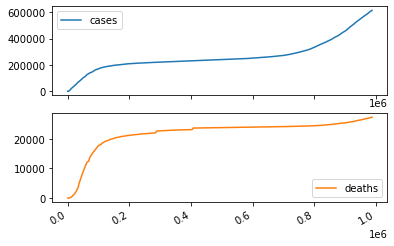

In [30]:
nyt[nyt["county"] == "New York City"][["cases", "deaths"]].plot(subplots = True)